In [1]:
import time
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import lightgbm as lgb
from itertools import cycle
from sklearn.svm import SVR
import statsmodels.api as sm
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

%matplotlib inline 
plt.style.use('seaborn-pastel')
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
calendar = pd.read_csv("../data/calendar.csv")
sales_train_evaluation = pd.read_csv("../data/sales_train_evaluation.csv")
sales_train_validation = pd.read_csv("../data/sales_train_validation.csv")
sell_prices = pd.read_csv("../data/sell_prices.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [3]:
df_melt = pd.melt(sales_train_evaluation, id_vars=sales_train_evaluation.columns[:6], 
                  value_vars=sales_train_evaluation.columns[6:], var_name = 'd', value_name = 'demand')

In [4]:
df_melt.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0
59181089,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1941,1


In [11]:
partial_cal = calendar[["d","weekday","month","year","event_name_1","event_name_2","date","wm_yr_wk"]].fillna("--")
df_merge = pd.merge(df_melt[['d','id','item_id','store_id','demand']], partial_cal)
print(df_merge.shape)
df_merge.tail()

(59181090, 12)


,d,id,item_id,store_id,demand,weekday,month,year,event_name_1,event_name_2,date,wm_yr_wk
59181085,d_1941,FOODS_3_823_WI_3_evaluation,FOODS_3_823,WI_3,1,Sunday,5,2016,--,--,2016-05-22,11617
59181086,d_1941,FOODS_3_824_WI_3_evaluation,FOODS_3_824,WI_3,0,Sunday,5,2016,--,--,2016-05-22,11617
59181087,d_1941,FOODS_3_825_WI_3_evaluation,FOODS_3_825,WI_3,2,Sunday,5,2016,--,--,2016-05-22,11617
59181088,d_1941,FOODS_3_826_WI_3_evaluation,FOODS_3_826,WI_3,0,Sunday,5,2016,--,--,2016-05-22,11617
59181089,d_1941,FOODS_3_827_WI_3_evaluation,FOODS_3_827,WI_3,1,Sunday,5,2016,--,--,2016-05-22,11617


In [10]:
import gc
gc.collect()

20

In [14]:
df_merge = pd.merge(df_merge,sell_prices, on = ["store_id", "item_id", "wm_yr_wk"])
print(df_merge.shape)
df_merge.tail()

(46881677, 13)


,d,id,item_id,store_id,demand,weekday,month,year,event_name_1,event_name_2,date,wm_yr_wk,sell_price
46881672,d_1941,FOODS_3_825_WI_3_evaluation,FOODS_3_825,WI_3,2,Sunday,5,2016,--,--,2016-05-22,11617,3.98
46881673,d_1940,FOODS_3_826_WI_3_evaluation,FOODS_3_826,WI_3,1,Saturday,5,2016,--,--,2016-05-21,11617,1.28
46881674,d_1941,FOODS_3_826_WI_3_evaluation,FOODS_3_826,WI_3,0,Sunday,5,2016,--,--,2016-05-22,11617,1.28
46881675,d_1940,FOODS_3_827_WI_3_evaluation,FOODS_3_827,WI_3,5,Saturday,5,2016,--,--,2016-05-21,11617,1.00
46881676,d_1941,FOODS_3_827_WI_3_evaluation,FOODS_3_827,WI_3,1,Sunday,5,2016,--,--,2016-05-22,11617,1.00


In [15]:
del calendar, sales_train_evaluation, sales_train_validation, sell_prices,df_melt ; gc.collect()

96

In [16]:
def lags_windows(df):
    lags = [7]
    lag_cols = ["lag_{}".format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","demand"]].groupby("id")["demand"].shift(lag)

    wins = [7]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df["rmean_{}_{}".format(lag,win)] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())   
    return df

def per_timeframe_stats(df, col):
    #For each item compute its mean and other descriptive statistics for each month and dayofweek in the dataset
    months = df['month'].unique().tolist()
    for y in months:
        df.loc[df['month'] == y, col+'_month_mean'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.mean()).astype("float32")
        df.loc[df['month'] == y, col+'_month_max'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.max()).astype("float32")
        df.loc[df['month'] == y, col+'_month_min'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.min()).astype("float32")
        df[col + 'month_max_to_min_diff'] = (df[col + '_month_max'] - df[col + '_month_min']).astype("float32")

    dayofweek = df['weekday'].unique().tolist()
    for y in dayofweek:
        df.loc[df['weekday'] == y, col+'_dayofweek_mean'] = df.loc[df['weekday'] == y].groupby(['id'])[col].transform(lambda x: x.mean()).astype("float32")
        df.loc[df['weekday'] == y, col+'_dayofweek_median'] = df.loc[df['weekday'] == y].groupby(['id'])[col].transform(lambda x: x.median()).astype("float32")
        df.loc[df['weekday'] == y, col+'_dayofweek_max'] = df.loc[df['weekday'] == y].groupby(['id'])[col].transform(lambda x: x.max()).astype("float32")
    return df

def feat_eng(df):
    df = lags_windows(df)
    df = per_timeframe_stats(df,'demand')
    return df

In [44]:
gc.collect()

55

In [46]:
data = df_merge.copy()

data['date'] = pd.to_datetime(data['date'])

# rolling demand features
tmp = data[['id','demand']].groupby(['id'])['demand']
data['lag_t28'] = tmp.transform(lambda x: x.shift(28))
data['lag_t29'] = tmp.transform(lambda x: x.shift(29))
data['lag_t30'] = tmp.transform(lambda x: x.shift(30))
data['rolling_mean_t7'] = tmp.transform(lambda x: x.shift(28).rolling(7).mean())
data['rolling_std_t7'] = tmp.transform(lambda x: x.shift(28).rolling(7).std())
data['rolling_mean_t30'] = tmp.transform(lambda x: x.shift(28).rolling(30).mean())
data['rolling_mean_t90'] = tmp.transform(lambda x: x.shift(28).rolling(90).mean())
data['rolling_mean_t180'] = tmp.transform(lambda x: x.shift(28).rolling(180).mean())
data['rolling_std_t30'] = tmp.transform(lambda x: x.shift(28).rolling(30).std())
data['rolling_skew_t30'] = tmp.transform(lambda x: x.shift(28).rolling(30).skew())
data['rolling_kurt_t30'] = tmp.transform(lambda x: x.shift(28).rolling(30).kurt())

data = feat_eng(data)

''

In [47]:
useless_cols = ['d','id','date','demand','wm_yr_wk']
lgb_train_cols = data.columns[~data.columns.isin(useless_cols)]
linreg_train_cols = lgb_train_cols#['sell_price','year','month','dayofweek','lag_7','rmean_7_7'] #use different columns for linear regression


from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
data['item_id'] = lbl.fit_transform(data['item_id'].astype(str))
data['store_id'] = lbl.fit_transform(data['store_id'].astype(str))
data['weekday'] = lbl.fit_transform(data['weekday'].astype(str))
data['event_name_1'] = lbl.fit_transform(data['event_name_1'].astype(str))
data['event_name_2'] = lbl.fit_transform(data['event_name_2'].astype(str))
data = data.fillna(0)

train = data[data['date'] <= '2016-03-27']
test = data[(data['date'] > '2016-03-11') & (data['date'] <= '2016-04-24')]

X_train = train[lgb_train_cols].copy()
y_train = train["demand"]

X_test = test[lgb_train_cols].copy()
y_test = test["demand"]

In [60]:
#Fit Light Gradient Boosting
t0 = time.time()
lgb_params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
        'num_iterations' : 2000,
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}
np.random.seed(777)
fake_valid_inds = np.random.choice(X_train.index.values, 365, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],free_raw_data=False)
m_lgb = lgb.train(lgb_params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 
#t_lgb = time.time()-t0

In [53]:
fday = datetime(2016,3, 28) 
max_lags = 15
for tdelta in range(0, 28):
    day = fday + timedelta(days=tdelta)
    tst = test[(test.date >= str(day - timedelta(days=max_lags))[:10]) & (test.date <= str(day)[:10])].copy()
    tst_lgb = tst.loc[tst.date == str(day)[:10] , lgb_train_cols].copy()
    test.loc[test.date == str(day)[:10], "preds_LightGB"] = m_lgb.predict(tst_lgb)
    
test_final = test.loc[test.date >= str(fday)[:10]]

In [57]:
m_lgb.save_model("model_mine.lgb")

In [54]:
predictions = test[["id","date"]]
stats = pd.DataFrame(columns=['Model Name','Execution Time','RMSE'])

RMSE for LightGB: 1.9965


NameError: name 't_lgb' is not defined

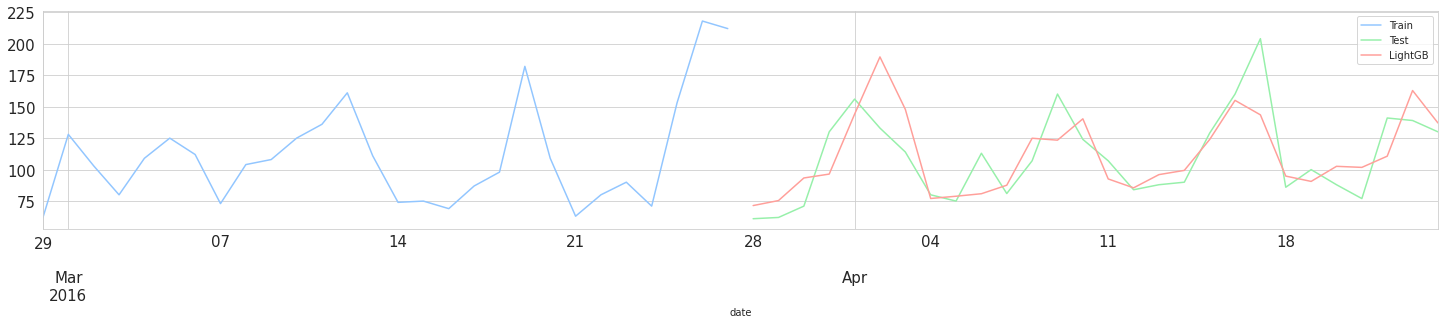

In [55]:
model_name='LightGB'
predictions[model_name] = test_final["preds_"+model_name]

#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[train["id"] == 'FOODS_3_090_CA_3_evaluation'][-28:].plot(x='date',y='demand',label='Train',ax=ax)
test_final[test_final["id"] == 'FOODS_3_090_CA_3_evaluation'].plot(x='date',y='demand',label='Test',ax=ax);
test_final[test_final["id"] == 'FOODS_3_090_CA_3_evaluation'].plot(x='date',y='preds_LightGB',label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(test_final['preds_LightGB'], test_final['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t_lgb, 'RMSE':score},ignore_index=True)

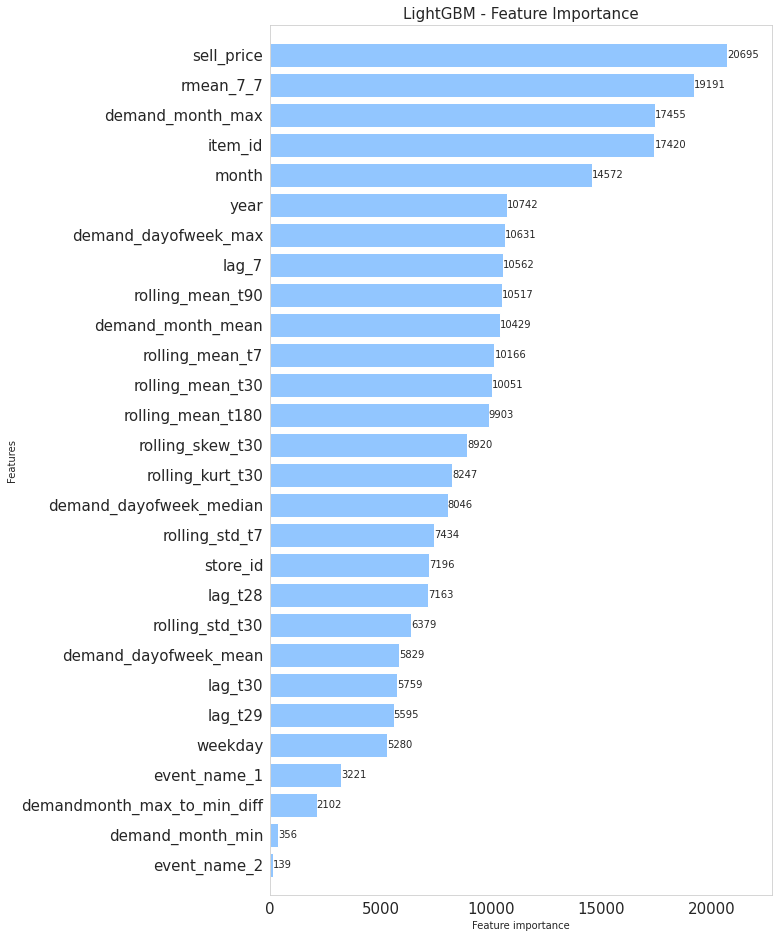

In [59]:
fig, ax = plt.subplots(figsize=(9,16)) #
lgb.plot_importance(m_lgb, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [43]:
stats.sort_values(by='RMSE')

,Model Name,Execution Time,RMSE
0,LinearReg,25.996787,3.553296
